# Exercise Sheet 6 <br/> CHE103 Übungen zu Anwendungen des Computers in der Chemie <br/> Spring Semester 2022

***

To hand in the exercise for feedback, upload this notebook containing your answers and your code back to OLAT before **Friday**. Handing in is **optional** but recommanded.

<div class="alert alert-warning">
    <b>Important</b>: Before uploading a notebook with your answers back to OLAT, you need to make sure that everything works as intended. To do so, start by clearing all the outputs of the notebook by going to the toolbar and clicking <mark>Edit -> Clear All Outputs</mark> and then rerun all cells with a fresh kernel using <mark>Kernel -> Restart Kernel</mark> followed by <mark>Run -> Run All Cells</mark>. You should then go through your answers and double-check that everything is correct.
</div>

## Introduction to Machine Learning using Support-vector machine

Alongside with this exercise notebook you should have also downloaded the `exercise_sheet06-tutorial.ipynb` notebook. Open that one and work through it to get an understanding about SVM and then come back to this exercise.

In this exercise we are going to reproduce a small portion of a review paper about using SVM in Chemistry:
[Ovidiu Ivanciuc. Applications of Support Vector Machines in Chemistry. In: Reviews in Computational Chemistry, Volume 23, Eds.: K. B. Lipkowitz and T. R. Cundari. Wiley-VCH, Weinheim, 2007, pp. 291–400.](https://onlinelibrary.wiley.com/doi/10.1002/9780470116449.ch6)

What we are looking at is the example about using SVM to classify (possibly) toxic organic compounds into 2 different classes based on their mechanism of action (MOA) using structural descriptors (which were obtained using a semi-empirical quantum calculation). The subset of compounds we're going to look at are narcotic pollutants and are considered to disrupt the functioning of cell membranes.  These narcotic pollutants are distinguished in their MOA being either polar (MOA 1) or nonpolar (MOA 2).
In the original paper [S. Ren. Classifying class I and class II compounds by hydrophobicity and hydrogen bonding descriptors](https://onlinelibrary.wiley.com/doi/pdf/10.1002/tox.10074) (you need to visit this URL while logged-in to a UZH Wifi network or using the UZH VPN to be able to obtain it) the authors used 5 structural descriptors:

* the octanol–water partition coefficient $\log(K_{ow})$
* the energy of the highest occupied molecular orbital $E_{HOMO}$
* the energy of the lowest unoccupied molecular orbital $E_{LUMO}$
* the most negative partial charge on any non-hydrogen atom in the molecule $Q^-$
* the most positive partial charge on a hydrogen atom $Q^+$

In the review papers the authors were able to obtain an equally good model on the same data using only 3 descriptors: $E_{HOMO}$, $E_{LUMO}$ and $Q^-$. And this is what you're going to try in this exercise!

As before, we are importing the usual libraries. Since we have 3 descriptors and not only 2 as in the tutorial, we are going to plot in 3D. Fear not, you will not have to deal with that particular challenge.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['figure.figsize'] = [12, 9]
seaborn.set()

### Prepare the data

A friendly tutor already pulled the data containing the list of compounds with their corresponding descriptors $\log(K_{ow})$, $E_{HOMO}$, $Q^-$, $E_{LUMO}$,  $Q^+$ and the assigned *MOA* from the original paper and prepared the CSV file `tox.csv` with the data.

Open the file (either in Jupyter or with Excel) to take a look!
Since some of the compound names contain commas, the tab character `\t` was used as a delimiter between the fields.

<div class="alert alert-success"><b>Task 1:</b> load the proper data from the file into variables <code>X</code> (array with 3 columns of <code>float</code>) and <code>cat</code> (the classification/MOA as an array of <code>int</code>).</div>

**Hints**:
* when reading the data, Python may read it only as strings (depending on how you load it) and you may have to convert the numerical data to `float` and the classification to an `int` manually.
* you may either do the import manually using methods like `read()` and `splitlines()` or using the `csv.reader` object presented in the previous exercises.
* the first line of the file is a header (title of the columns), it should be ignored.
* the file contains the data for all 5 descriptors, but we only need $E_{HOMO}$, $Q^-$, $E_{LUMO}$
* You can convert a list into a NumPy array using <code>my_array = np.array(my_list)</code>

<div class="alert alert-success"><b>Task 2:</b> to be able to test the model we want to take 20 compounds out of the complete list, to see whether the model is able to predict their MOA. The list of compounds to be taken out is given in the file <code>testcompounds.txt</code>. Read that file and create a list containing the test compounds. Based on this list, separate from the training data set <code>X</code> and <code>cat</code> a test set <code>testX</code> and <code>testcat</code> (that only covers the componds in <code>testcompounds.txt</code>).</div>

**Hint**: you can combine tasks 1 and 2 and directly separate the training and test data when reading `tox.csv`.

In [2]:
# your code for tasks 1 & and 2 here:
import csv
with open("testcompounds.txt", "r") as tox:
    testlabels = tox.read().splitlines()

compounds = []
data = []
testcompounds = []
testdata = []

with open("tox.csv", "r") as tox:
    for line in tox:
        entries = line.split("\t")
        
        
        if entries[0] == "Compound":
            # ignore the first line by directly jumping to the next iteration
            continue

        compound = entries[0]
        values = [float(v) for v in entries[1:]]  # convert the rest to a list of floats
        
        # depending on whether the compound occurs in the list testlabels
        if compound in testlabels:
            # add its label and values to the testcompounds and testdata list
            testcompounds.append(compound)
            testdata.append(values)
        else:
            # or if not, the the compounds and data lists
            compounds.append(compound)
            data.append(values)

# convert nested list to Numpy array for convenience
data = np.array(data)
testdata = np.array(testdata)         #

# and then use NumPy-based indexing to pull out the required columns from the data
X = data[:,1:4]                        #Daten von Ehomo, Q- und Elumo 
cat = data[:,-1].astype(int)

# do the same for the test data
testX = testdata[:,1:4]
testcat = testdata[:,-1].astype(int)
print(cat)
print(data)
print(X)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[[ -0.77   -11.135   -0.5353   3.7775   0.3182   1.    ]
 [ -0.31   -11.05    -0.536    3.6513   0.3107   1.    ]
 [  0.25   -10.94    -0.5317   3.6324   0.3122   1.    ]
 ...
 [  1.37    -9.254   -0.9468  -0.9503   0.3922   2.    ]
 [  1.39    -9.16    -0.6493   0.705    0.3134   2.    ]
 [  2.38    -8.994   -0.807   -0.8747   0.3969   2.    ]]
[[-11.135   -0.5353   3.7775]
 [-11.05    -0.536    3.6513]
 [-10.94    -0.5317   3.6324]
 [-10.895   -0.5469   3.4925]
 [-10.94    -0.5422   3.5041]
 [-10.952   -0.5456   3.5536]
 [-10.858   -0.5476   3.5052]
 [-10.991   -0.5517   3.4384]
 [-10.94    -0.5422   3.5041]
 [-10.805   -0.5394   3.4884]
 [-10.

### Generate the model

<div class="alert alert-success"><b>Task 3:</b> Using the data, fit the model as shown in the tutorial. To see whether it succeeds (besides that it shouldn't give an error) we provided a cell to plot the data (in a 3D plot) and the separating plane.</div>

In [3]:
# the code to generate the model here:
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(X, cat)


SVC(kernel='linear')

The plot of the following cell should match the one given below if you did everything correctly (makse sure you use `X` as variable name for the training data and `cat` for the categories, and `clf` for the SVM):

![control plot](control_plot.png)

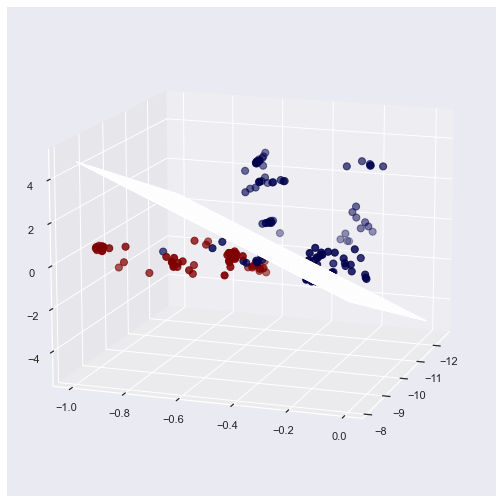

In [4]:
#DO NOT MODIFY: this is simply a way to check of your model is correct by plotting the same figure as above
def get_z(clf, x, y):
    """Function to get the z-component of the plain, given the fitted SVC object and x, and y grids"""
    return (-clf.intercept_[0] - clf.coef_[0][0]*x-clf.coef_[0][1]*y) / clf.coef_[0][2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=cat, s=50, cmap='seismic')

gridx, gridy = np.meshgrid(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100),
                           np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100))

zvalues = get_z(clf, gridx, gridy)
#               ^^^ here we assumed that the variable for the SVC model is called clf
#                   if you changed it, update it here as well!

ax.plot_surface(gridx, gridy, zvalues, color="black", alpha=0.6)
ax.view_init(elev=14, azim=19)

### Compare predictions for the testdata

<div class="alert alert-success"><b>Task 4:</b> For each compound in the <code>testdata</code> set: calculate the prediction, compare to the given classification and print the compound and whether the model was successful in predicting its class.

In [5]:
# your code here:
predictions = clf.predict(testX)

for compound, prediction, record in zip(testcompounds, predictions, testcat):
    print(f"{compound}, recorded: {record}, predicted: {prediction} {'✔' if record == prediction else '❌'}")

4-methyl-2-pentanone, recorded: 1, predicted: 1 ✔
2,4-dichloroacetophenone, recorded: 1, predicted: 2 ❌
cyclohexanone, recorded: 1, predicted: 1 ✔
ethyl acetate, recorded: 1, predicted: 1 ✔
dichloromethane, recorded: 1, predicted: 1 ✔
1,2-dichloroethane, recorded: 1, predicted: 1 ✔
1,1,2,2-tetrachloroethane, recorded: 1, predicted: 1 ✔
1,3-dichloropropane, recorded: 1, predicted: 1 ✔
tetrachloroethene, recorded: 1, predicted: 1 ✔
1,2,4-trimethylbenzene, recorded: 1, predicted: 1 ✔
4-nitrotoluene, recorded: 2, predicted: 2 ✔
3-chloronitrobenzene, recorded: 2, predicted: 2 ✔
2,4-dimethylphenol, recorded: 2, predicted: 2 ✔
2,4,6-trimethylphenol, recorded: 2, predicted: 2 ✔
4-ethylphenol, recorded: 2, predicted: 2 ✔
4-methylaniline, recorded: 2, predicted: 2 ✔
4-ethylaniline, recorded: 2, predicted: 2 ✔
2-chloroaniline, recorded: 2, predicted: 2 ✔
pentafluoroaniline, recorded: 2, predicted: 2 ✔
2-chloro-4-nitroaniline, recorded: 2, predicted: 2 ✔
